In [8]:
from typing import Dict, Optional, Tuple
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum

from Input_generator import generate_input  

In [9]:
# ---------------- Algorithm 1 with unit commitment ---------------- #

def solve_algorithm1_uc(
    params: Dict,
    prices: np.ndarray,           # shape (T,)
    inflows: np.ndarray,          # shape (T, J)
    l0: np.ndarray,               # shape (J,)
    u0: Optional[np.ndarray] = None,           # initial on/off (J,)
    phi_terminal: Optional[np.ndarray] = None  # salvage value for l_{T+1} (J,)
) -> Tuple[float, Dict[str, np.ndarray]]:
    """
    Maximize sum_t ρ_t * (α^T π_t) - λ^T ν_t + φ^T l_{T+1}
    s.t.
      l_{t+1} = l_t + r_t - π_t
      l^min ≤ l_{t+1} ≤ l^max
      u_t * π^min ≤ π_t ≤ u_t * π^max
      ν_t ≥ u_t - u_{t-1}
      u_t, ν_t ∈ {0,1}^J
    """
    J = int(params["J"]); T = int(params["T"])
    pi_min = params["pi_min"]; pi_max = params["pi_max"]
    l_min  = params["l_min"];  l_max  = params["l_max"]
    alpha  = params["alpha_energy"]
    lam    = params["lambda_startup"]  # startup costs λ (J,)

    if u0 is None:
        u0 = np.zeros(J, dtype=int)
    if phi_terminal is None:
        phi_terminal = np.zeros(J)

    m = Model("Alg1_UC")
    m.Params.OutputFlag = 0

    J_idx = range(J); T_idx = range(T)

    # Variables
    l = {(t, j): m.addVar(lb=float(l_min[j]), ub=float(l_max[j]), name=f"l[{t},{j}]")
         for t in range(1, T+1) for j in J_idx}
    l_Tp1 = {j: m.addVar(lb=float(l_min[j]), ub=float(l_max[j]), name=f"l[{T+1},{j}]")
             for j in J_idx}
    pi = {(t, j): m.addVar(lb=0.0, ub=float(pi_max[j]), name=f"pi[{t},{j}]")
          for t in T_idx for j in J_idx}
    u  = {(t, j): m.addVar(vtype=GRB.BINARY, name=f"u[{t},{j}]")
          for t in T_idx for j in J_idx}
    nu = {(t, j): m.addVar(vtype=GRB.BINARY, name=f"nu[{t},{j}]")
          for t in T_idx for j in J_idx}

    # Water balance l_{t+1} = l_t + r_t - π_t
    for j in J_idx:
        m.addConstr(l[(1, j)] == float(l0[j]) + float(inflows[0, j]) - pi[(0, j)], name=f"bal[0->1,{j}]")
    for t in range(1, T):
        for j in J_idx:
            m.addConstr(l[(t+1, j)] == l[(t, j)] + float(inflows[t, j]) - pi[(t, j)], name=f"bal[{t}->{t+1},{j}]")
    for j in J_idx:
        m.addConstr(l_Tp1[j] == l[(T, j)] + float(inflows[T-1, j]) - pi[(T-1, j)], name=f"bal[{T}->{T+1},{j}]")

    # Commitment bounds
    for t in T_idx:
        for j in J_idx:
            m.addConstr(pi[(t, j)] >= float(pi_min[j]) * u[(t, j)], name=f"minflow[{t},{j}]")
            m.addConstr(pi[(t, j)] <= float(pi_max[j]) * u[(t, j)], name=f"maxflow[{t},{j}]")

    # Startup logic ν_t ≥ u_t - u_{t-1}  (+ standard tightening)
    for j in J_idx:
        m.addConstr(nu[(0, j)] >= u[(0, j)] - float(u0[j]), name=f"startup[0,{j}]")
        m.addConstr(nu[(0, j)] <= u[(0, j)], name=f"startup_cap1[0,{j}]")
        m.addConstr(nu[(0, j)] <= 1 - float(u0[j]), name=f"startup_cap2[0,{j}]")
    for t in range(1, T):
        for j in J_idx:
            m.addConstr(nu[(t, j)] >= u[(t, j)] - u[(t-1, j)], name=f"startup[{t},{j}]")
            m.addConstr(nu[(t, j)] <= u[(t, j)], name=f"startup_cap1[{t},{j}]")
            m.addConstr(nu[(t, j)] <= 1 - u[(t-1, j)], name=f"startup_cap2[{t},{j}]")

    # Objective
    rev = quicksum(float(prices[t]) * quicksum(float(alpha[j]) * pi[(t, j)] for j in J_idx) for t in T_idx)
    su_cost = quicksum(float(lam[j]) * nu[(t, j)] for t in T_idx for j in J_idx)
    salvage = quicksum(float(phi_terminal[j]) * l_Tp1[j] for j in J_idx)
    m.setObjective(rev - su_cost + salvage, GRB.MAXIMIZE)

    m.optimize()
    if m.Status != GRB.OPTIMAL:
        raise RuntimeError(f"Gurobi status not optimal: {m.Status}")

    # Extract solution
    L = np.zeros((T+1, J)); L[0, :] = l0
    for t in range(1, T+1):
        for j in J_idx:
            L[t, j] = l[(t, j)].X

    PI = np.zeros((T, J)); U = np.zeros((T, J), dtype=int); NU = np.zeros((T, J), dtype=int)
    for t in T_idx:
        for j in J_idx:
            PI[t, j] = pi[(t, j)].X
            U[t, j]  = int(round(u[(t, j)].X))
            NU[t, j] = int(round(nu[(t, j)].X))

    return m.ObjVal, {"l": L, "pi": PI, "u": U, "nu": NU}



In [10]:
# ---------------- Plot ---------------- #

def plot_discharge(PI, title="Discharge schedule", ylabel="Discharge (10^3 m³/h)"):
    T, J = PI.shape
    t = np.arange(1, T+1)
    plt.figure(figsize=(10, 5))
    for j in range(J):
        plt.plot(t, PI[:, j], label=f"Reservoir {j+1}")
    plt.xlabel("Hour")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.show()

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-26
Scenario 0 | Objective: 50,523.29


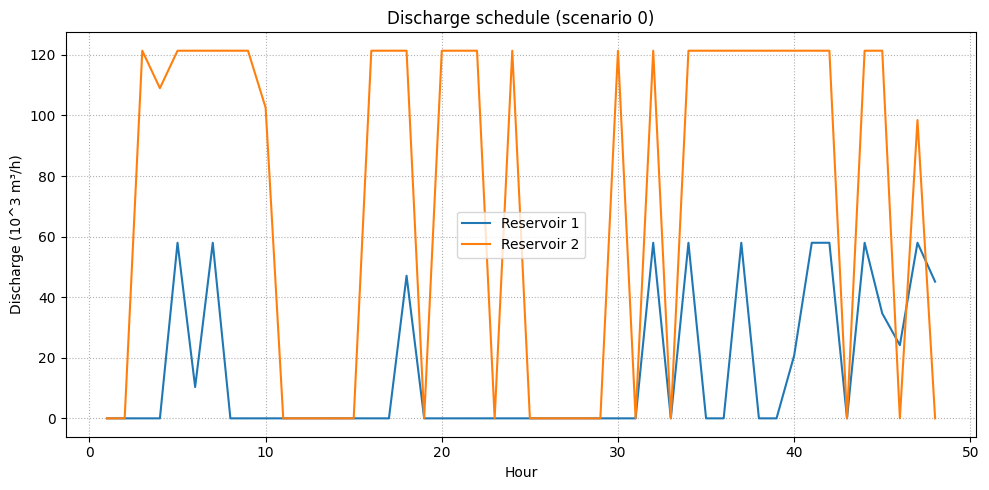

In [11]:
# ---------------- Wire up your generator ---------------- #

def main(N: int = 200, scenario_index: int = 0):
    # Unpack exactly as your generator returns
    (J, T, l_max, l_min, l0, pi_max, pi_min,
     price_samples, inflow_samples, nu0, rho0, R,
     a_t, b_t, l_bar, alpha_energy) = generate_input(N)

    # Build params dict for the solver
    params = {
        "J": J, "T": T,
        "pi_min": np.asarray(pi_min, dtype=float),
        "pi_max": np.asarray(pi_max, dtype=float),
        "l_min":  np.asarray(l_min, dtype=float),
        "l_max":  np.asarray(l_max, dtype=float),
        "alpha_energy": np.asarray(alpha_energy, dtype=float),
        # You didn’t provide startup costs; default to zeros (edit if needed)
        "lambda_startup": np.zeros(J, dtype=float),
    }

    # Pick one scenario (you can loop over many if you like)
    s = int(np.clip(scenario_index, 0, N-1))
    prices = np.asarray(price_samples[s], dtype=float)      # (T,)
    inflows = np.asarray(inflow_samples[s], dtype=float)    # (T, J)

    # Optional terminal value proxy (small fraction of value of water)
    kappa = 0.2
    phi_terminal = params["alpha_energy"] * prices[-1] * kappa

    obj, sol = solve_algorithm1_uc(params, prices, inflows, l0=np.asarray(l0, float),
                                   u0=None, phi_terminal=phi_terminal)
    print(f"Scenario {s} | Objective: {obj:,.2f}")

    # Plot discharge schedule
    plot_discharge(sol["pi"], title=f"Discharge schedule (scenario {s})")

if __name__ == "__main__":
    main(N=200, scenario_index=0)
